In [223]:
# Loading packages

import numpy as np
import pandas as pd
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK Stop words
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['tcs', 'wipro', 'infosys', 'hcl','from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [227]:
raw = pd.read_csv(r'C:\Users\Anindita\Documents\ISB\Capstone Project\Projects\Capstone Peak Health\Files\combinedReviews.csv')
raw.head()

,Unnamed: 0,skillDevelopment,reviewText,location,cons,salaryBenefits,workLifeBalance,pros,workSatisfaction,postedon,jobSecurity,careerGrowth,companyCulture,company,jobFunction,overallScore,file
0,0,1.0,Its good and managable only because of team.,Lucknow,Fake offers were given while recruiting. Wrong...,1.0,3.0,Only my collegues and work culture. There is n...,3.0,21-Apr-22,4.0,1.0,4.0,HCL Technologies,Hr Executive,1.0,hcl
1,1,4.0,Very balanced and rarely pressuring.,Noida,* Although it's WFH as of now but no general t...,2.0,5.0,Overall good experience for me! Very much secu...,4.0,16-Apr-22,5.0,4.0,3.0,HCL Technologies,Technical Lead,4.0,hcl
2,2,3.0,working hours are 9:30 hours no shift allowanc...,Greater Noida,Management always listen what the manager sayi...,2.0,3.0,Job security is there Client or Customer centr...,1.0,20-Apr-22,4.0,2.0,2.0,HCL Technologies,Senior Specialist,3.0,hcl
3,3,1.0,Too bad for a mid level experienced. Enquire p...,Chennai,Work culture is too bad and experienced so man...,1.0,2.0,It is a growing organization and has multiple ...,1.0,09-Dec-21,4.0,1.0,1.0,HCL Technologies,Senior Technical Lead,1.0,hcl
4,4,1.0,Is there anything called work life balance her...,Chennai,Why not paying your employees good!? .Stop ove...,4.0,1.0,"Hcl is avery good organization,But the middle ...",1.0,04-Mar-22,4.0,1.0,1.0,HCL Technologies,Software Engineer,1.0,hcl


In [228]:
df=raw[['cons']]

In [229]:
df=df.dropna(axis=0)

In [230]:
df.head()

,cons
0,Fake offers were given while recruiting. Wrong...
1,* Although it's WFH as of now but no general t...
2,Management always listen what the manager sayi...
3,Work culture is too bad and experienced so man...
4,Why not paying your employees good!? .Stop ove...


In [231]:
# Data Cleaning

import re
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("","",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
       
    # remove all single characters
    text=re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
        
    # remove non-ascii characters
    text=re.sub(r'[^\x00-\x7f]'," ", text)
    
    # remove non-english characters
    text=re.sub("[^a-zA-Z0-9]+"," ",text)
    
    return text

df['cons_preprocess'] = df['cons'].apply(lambda x:pre_process(x))

clean_reviews = pd.DataFrame(df.cons_preprocess)

### Forming Bigrams and Trigrams
Identifying bigrams and trigrams and then concatenating them and considering them as one word. Pointwise Mutual Information(PMI) score is used to identify significant bigrams and trigrams for concatenation. We also filter bigrams or trigrams with the filter (noun/adj, noun), (noun/adj,all types,noun/adj) because these are common structures pointing out noun-type n-grams. This helps the LDA model better cluster topics.

Collocations are phrases or expressions containing multiple words, that are highly likely to co-occur.Just considering co-occuring words(like bigrams and trigrams) might not be meaningful, hence we need collocations.PMI score is used for rating the collocations

In [232]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in clean_reviews.cons_preprocess])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [233]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in clean_reviews.cons_preprocess])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [234]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [235]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [236]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_words or bigram[1] in stop_words:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

In [237]:
# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_words or trigram[-1] in stop_words or trigram[1] in stop_words:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True 

In [238]:
trigram_pmi.head(50)

,trigram,pmi
0,"(na, na, na)",22.936332
1,"(address, our, issues)",19.414012
2,"(doesn, address, our)",19.094877
3,"(management, doesn, address)",16.557852
4,"(cannot, resign, on)",16.392448
5,"(you, cannot, resign)",16.125431
6,"(straight, in, day)",16.045450
7,"(years, before, which)",15.982486
8,"(when, it, comes)",15.854169
9,"(could, have, been)",15.479768


In [239]:
# Choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)][:500]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [240]:
# examples of bigrams
bigrams[:10]

['third party',
 'cost cutting',
 'notice period',
 'rotational shifts',
 'cannot resign',
 'new joinees',
 'related travel',
 'long term',
 'industry standards',
 'cab facility']

In [241]:
# examples of trigrams
trigrams[:10]

['work related travel',
 'long working hours',
 'work hours straight',
 'work life balance',
 'career growth opportunities',
 'slow career growth',
 'poor work life',
 'salary appraisal politics',
 'less career growth',
 'appraisal career growth']

In [242]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [243]:
reviews_w_ngrams = clean_reviews.copy()

In [244]:
reviews_w_ngrams.cons_preprocess = reviews_w_ngrams.cons_preprocess.map(lambda x: replace_ngram(x))

In [245]:
# tokenize reviews + remove stop words + remove words with less than 2 characters
reviews_w_ngrams = reviews_w_ngrams.cons_preprocess.map(lambda x: [word for word in x.split()\
                                                 if word not in stop_words\
                                                              and len(word) > 2])

In [246]:
reviews_w_ngrams.head()

0    [fake, offers, given, recruiting, wrong, infor...
1    [although, wfh, general, transportation, avail...
2    [management, always, listen, manager, saying, ...
3    [work, culture, bad, experienced, mind, games,...
4    [paying, employees, stop, overloading, familie...
Name: cons_preprocess, dtype: object

Nouns are most likely indicators of a topic. For example, for the sentence ‘The store is nice’, we know the sentence is talking about ‘store’. The other words in the sentence provide more context and explanation about the topic (‘store’) itself. Therefore, filtering for the noun cleans the text for words that are more interpretable in the topic model.

In [247]:
# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

### LDA Model

In [248]:
final_reviews = reviews_w_ngrams.map(noun_only)

In [249]:
dictionary = corpora.Dictionary(final_reviews)

In [250]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_reviews]

LDA requires that we specify the number of topics that exists in a corpus of text. There are several common measures that can be optimized, such as predictive likelihood, perplexity, and coherence. Much literature has indicated that maximizing coherence, particularly a measure named Cv (https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf), leads to better human interpretability. This measure assesses the interpretability of topics given the set of words in generated topics. Therefore, we will optimize this measure.

We rae trying here topcis from 3-23

In [190]:
coherence = []
for k in range(3,23):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,\
                   iterations=200, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_reviews,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22


In [191]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

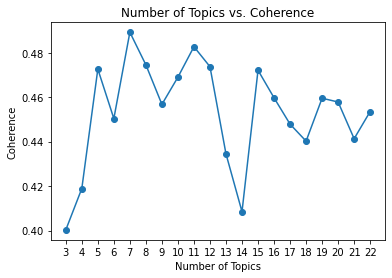

In [192]:
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

The improvement stops to significantly improve after 11 topics. It is not always where the highest Cv is, so we can try a couple to see which has the best result. We'll try 5, 7, 11 and 15 here. Adding topics can help reveal further sub topics.

In [193]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [194]:
Lda2 = gensim.models.ldamodel.LdaModel
ldamodel2 = Lda2(doc_term_matrix, num_topics=7, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [195]:
Lda3 = gensim.models.ldamodel.LdaModel
ldamodel3 = Lda3(doc_term_matrix, num_topics=11, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [202]:
Lda4 = gensim.models.ldamodel.LdaModel
ldamodel4 = Lda4(doc_term_matrix, num_topics=15, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

In [196]:
ldamodel.show_topics(5, num_words=10, formatted=False)

[(0,
  [('company', 0.10994456),
   ('career_growth', 0.087423615),
   ('work', 0.051517528),
   ('dislike', 0.04089415),
   ('job', 0.029997487),
   ('experience', 0.029196123),
   ('job_security', 0.026830506),
   ('environment', 0.024403794),
   ('process', 0.024223274),
   ('opportunity', 0.017526563)]),
 (1,
  [('hike', 0.13340004),
   ('project', 0.10445503),
   ('increment', 0.04334637),
   ('promotion', 0.040857296),
   ('manager', 0.02912862),
   ('package', 0.02272041),
   ('policy', 0.019208934),
   ('career', 0.016481413),
   ('technology', 0.016230226),
   ('development', 0.01514805)]),
 (2,
  [('nothing', 0.2805767),
   ('growth', 0.16772197),
   ('work', 0.13000965),
   ('culture', 0.05995559),
   ('pressure', 0.038426332),
   ('pay', 0.037811764),
   ('place', 0.01688629),
   ('satisfaction', 0.007225962),
   ('opportunity', 0.006665471),
   ('quality', 0.005024056)]),
 (3,
  [('work_life_balance', 0.06417637),
   ('work', 0.053607155),
   ('time', 0.046532977),
   ('te

In [197]:
ldamodel2.show_topics(7, num_words=10, formatted=False)

[(0,
  [('work', 0.07379299),
   ('dislike', 0.05301071),
   ('project', 0.044662356),
   ('job', 0.038885098),
   ('experience', 0.037846297),
   ('job_security', 0.03477954),
   ('company', 0.03423011),
   ('environment', 0.031633787),
   ('client', 0.02098176),
   ('day', 0.017935969)]),
 (1,
  [('hike', 0.1986731),
   ('project', 0.092185736),
   ('process', 0.05852056),
   ('package', 0.03383565),
   ('manager', 0.031021025),
   ('year', 0.02328835),
   ('performance', 0.02025042),
   ('promotion', 0.019961834),
   ('rating', 0.018318139),
   ('salary_structure', 0.017596032)]),
 (2,
  [('nothing', 0.3282494),
   ('growth', 0.19622056),
   ('work', 0.1288149),
   ('culture', 0.0701418),
   ('pressure', 0.04495417),
   ('pay', 0.033134002),
   ('place', 0.012592633),
   ('shift', 0.0066926647),
   ('rate', 0.004761638),
   ('cab', 0.0044991444)]),
 (3,
  [('company', 0.105010115),
   ('work_life_balance', 0.083730824),
   ('time', 0.0607111),
   ('work', 0.04717601),
   ('opportuni

In [198]:
ldamodel3.show_topics(11, num_words=10, formatted=False)

[(0,
  [('dislike', 0.12161876),
   ('job', 0.0892104),
   ('job_security', 0.079791114),
   ('company', 0.04272756),
   ('day', 0.0411469),
   ('join', 0.026216332),
   ('performance', 0.021462962),
   ('appreciation', 0.017980786),
   ('dont', 0.015232882),
   ('something', 0.014622936)]),
 (1,
  [('career_growth', 0.21660335),
   ('project', 0.2095023),
   ('manager', 0.06972185),
   ('package', 0.045564603),
   ('level', 0.028356772),
   ('development', 0.024670849),
   ('release', 0.019246982),
   ('low', 0.016170578),
   ('point', 0.011908829),
   ('cannot', 0.010306244)]),
 (2,
  [('nothing', 0.6568497),
   ('pay', 0.08851448),
   ('shift', 0.020413032),
   ('satisfaction', 0.010786186),
   ('industry', 0.010223925),
   ('rmg', 0.0098068165),
   ('project_allocation', 0.007930421),
   ('payment', 0.007817634),
   ('learn', 0.00743438),
   ('carrer_growth', 0.00641825)]),
 (3,
  [('company', 0.16542213),
   ('time', 0.083591655),
   ('support', 0.029476563),
   ('life', 0.0245804

In [203]:
ldamodel4.show_topics(15, num_words=10, formatted=False)

[(0,
  [('company', 0.3923307),
   ('dislike', 0.14592148),
   ('job_security', 0.09573475),
   ('chance', 0.023558272),
   ('job', 0.018863939),
   ('learn', 0.01770872),
   ('please', 0.015306021),
   ('thing', 0.015086476),
   ('business', 0.014345484),
   ('grow', 0.013263545)]),
 (1,
  [('hike', 0.34222153),
   ('project', 0.26796505),
   ('package', 0.058278255),
   ('release', 0.024616247),
   ('cab', 0.015421585),
   ('name', 0.014604977),
   ('technology', 0.011609544),
   ('move', 0.010636976),
   ('resource', 0.0104357395),
   ('choice', 0.010213911)]),
 (2,
  [('nothing', 0.7309773),
   ('pay', 0.09850201),
   ('bonus', 0.013466925),
   ('money', 0.011301247),
   ('project_allocation', 0.008823436),
   ('payment', 0.008698007),
   ('behaviour', 0.007852696),
   ('increament', 0.0068284017),
   ('bpo', 0.006337009),
   ('world', 0.005589985)]),
 (3,
  [('manager', 0.11504724),
   ('life', 0.039763983),
   ('none', 0.03919305),
   ('person', 0.031524837),
   ('year', 0.031355

### Relevancy
Sometimes, words that are ranked as top words for a given topic may be ranked high because they are globally frequent across text in a corpus. Relevancy score helps to prioritize terms that belong more exclusively to a given topic. This can increase interpretability even more. Lowering the lambda value we see the relevance of the words to the topics.

In [199]:
lda_viz = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary, mds = 'pcoa')
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.091272 -0.105216       1        1  23.702706
0      0.142215 -0.067939       2        1  22.403718
1     -0.110844 -0.268406       3        1  19.064784
4     -0.351846  0.192226       4        1  17.623622
2      0.229203  0.249335       5        1  17.205169, topic_info=             Term         Freq        Total Category  logprob  loglift
31        nothing  8095.000000  8095.000000  Default  30.0000  30.0000
11   compensation  6777.000000  6777.000000  Default  29.0000  29.0000
58         growth  4839.000000  4839.000000  Default  28.0000  28.0000
61     management  4677.000000  4677.000000  Default  27.0000  27.0000
18           hike  4265.000000  4265.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
680         learn    88.722279   186.804271   Topic5  -5.7844   1.0154
41            ctc    76.334672   154.968994   Topic5  -5.9348   1.0519
145        career   140.621259   981.208337   Topic5  -5.3238  -0.1828
288           bpo    61.278483   118.372185   Topic5  -6.1545   1.1016
90    recognition    69.974902   391.841172   Topic5  -6.0218   0.0372

[235 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1463      4  0.982696        action
205       4  0.998500       address
225       2  0.997971      anything
53        4  0.999715     appraisal
308       2  0.996060  appreciation
...     ...       ...           ...
204       4  0.648179     work_load
95        1  0.260975          year
95        2  0.107290          year
95        3  0.630691          year
363       5  0.980573   yearly_hike

[234 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 5, 3])

In [200]:
lda_viz = gensimvis.prepare(ldamodel2, doc_term_matrix, dictionary, mds = 'pcoa')
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.131201  0.093648       1        1  17.847247
0      0.159940  0.033599       2        1  17.575573
5      0.090763 -0.041885       3        1  15.043016
2      0.167468 -0.286610       4        1  13.869527
1     -0.056310  0.162583       5        1  12.960394
6     -0.373761 -0.188269       6        1  11.516827
4     -0.119302  0.226934       7        1  11.187416, topic_info=             Term         Freq        Total Category  logprob  loglift
31        nothing  7635.000000  7635.000000  Default  30.0000  30.0000
11   compensation  6783.000000  6783.000000  Default  29.0000  29.0000
61     management  4781.000000  4781.000000  Default  28.0000  28.0000
58         growth  4564.000000  4564.000000  Default  27.0000  27.0000
18           hike  4318.000000  4318.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
142           way   234.109007   441.681024   Topic7  -4.3837   1.5556
320          rest    93.359784   109.892590   Topic7  -5.3030   2.0273
62        manager   223.518863  1612.483829   Topic7  -4.4300   0.2143
77    development    90.400283   479.413110   Topic7  -5.3353   0.5221
33         policy    91.284369   796.896025   Topic7  -5.3255   0.0236

[320 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1463      7  0.995147       action
205       3  0.997784      address
1217      7  0.982891   allocation
771       6  0.987056  annual_hike
225       7  0.997792     anything
...     ...       ...          ...
1984      7  0.986954     workload
294       3  0.992771        world
95        2  0.274707         year
95        5  0.723967         year
363       4  0.984830  yearly_hike

[344 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 6, 3, 2, 7, 5])

In [201]:
lda_viz = gensimvis.prepare(ldamodel3, doc_term_matrix, dictionary, mds = 'pcoa')
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.186400 -0.190798       1        1  13.678754
7     -0.324845 -0.094249       2        1  11.927015
10    -0.287789 -0.125505       3        1   9.708486
1      0.039760 -0.039334       4        1   9.515526
5      0.043727  0.027050       5        1   9.489270
0      0.175086 -0.178642       6        1   8.440788
8     -0.010060  0.292488       7        1   8.172024
4      0.064531  0.070488       8        1   7.847826
2      0.010952  0.215006       9        1   7.159216
6      0.089560 -0.049045      10        1   7.149884
9      0.012679  0.072542      11        1   6.911212, topic_info=             Term         Freq        Total Category  logprob  loglift
31        nothing  7886.000000  7886.000000  Default  30.0000  30.0000
11   compensation  6731.000000  6731.000000  Default  29.0000  29.0000
94           work  8046.000000  8046.000000  Default  28.0000  28.0000
61     management  4886.000000  4886.000000  Default  27.0000  27.0000
58         growth  4841.000000  4841.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
330       service   132.843202   235.974806  Topic11  -4.4687   2.0975
47         system   148.870040   359.653269  Topic11  -4.3548   1.7900
386        option    93.843330   166.381657  Topic11  -4.8162   2.0994
192       support    93.739291   770.691773  Topic11  -4.8173   0.5653
138        market    74.766706   400.631954  Topic11  -5.0435   0.9934

[471 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
339      10  0.996967      account
1463      8  0.991008       action
205       5  0.999097      address
1217      4  0.990796   allocation
52        1  0.339040    allowance
...     ...       ...          ...
95       10  0.159780         year
363       9  0.987873  yearly_hike
286       3  0.752358          yrs
286       4  0.236455          yrs
169       3  0.985946         zero

[506 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 8, 11, 2, 6, 1, 9, 5, 3, 7, 10])

In [204]:
lda_viz = gensimvis.prepare(ldamodel4, doc_term_matrix, dictionary, mds = 'pcoa')
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3     -0.118218  0.142716       1        1  9.049518
11     0.210125  0.077398       2        1  8.072941
5     -0.086288 -0.138672       3        1  7.627554
1     -0.095400 -0.095131       4        1  7.353570
7      0.258655 -0.033923       5        1  7.125749
0     -0.084921  0.222076       6        1  6.896999
8      0.304723 -0.008562       7        1  6.631611
10     0.233737 -0.009039       8        1  6.385089
4     -0.085906 -0.099383       9        1  6.254944
9     -0.095602  0.152224      10        1  6.108516
13    -0.092093  0.193758      11        1  6.077687
2     -0.083640 -0.195114      12        1  6.043040
6     -0.085990 -0.009840      13        1  5.820655
12    -0.100241 -0.138279      14        1  5.417214
14    -0.078942 -0.060228      15        1  5.134913, topic_info=              Term         Freq        Total Category  logprob  loglift
31         nothing  7408.000000  7408.000000  Default  30.0000  30.0000
11    compensation  6648.000000  6648.000000  Default  29.0000  29.0000
58          growth  5219.000000  5219.000000  Default  28.0000  28.0000
94            work  8598.000000  8598.000000  Default  27.0000  27.0000
61      management  4782.000000  4782.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
1595        method    12.822499    13.787119  Topic15  -6.5096   2.8966
2160     mechanism    12.715952    13.680573  Topic15  -6.5179   2.8960
1992     reference    12.686204    13.650824  Topic15  -6.5203   2.8958
170         amount    74.280512   206.019192  Topic15  -4.7529   1.9490
1141    innovation    53.686739   172.716509  Topic15  -5.0776   1.8006

[589 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
339       1  0.996409         account
1463      9  0.982366          action
205       3  0.997548         address
825      14  0.978643  administration
1211     15  0.967445       advantage
...     ...       ...             ...
95        4  0.139525            year
95       13  0.227226            year
363      12  0.976325     yearly_hike
169       3  0.651207            zero
169      10  0.341108            zero

[630 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 12, 6, 2, 8, 1, 9, 11, 5, 10, 14, 3, 7, 13, 15])

The pyLDAvis tool also gives two other important pieces of information. The circles represent each topic and the distance between the circles visualizes how related topics are to each other. 

In our case, **LDAmodel2** shows that our topics are quite distinct. The dimensionality reduction chosen is t-sne. Additionally, the size of the circle represents how prevalent that topic is across the corpus of reviews. For example, topic 1 in this case makes up the majority of the documents, constituting 17.1% of the tokens.